Aprile, Amezquita, Schaber <br>
CPE-695 Final Project <br>
Facial Expression Detection with Limited Features

# <font color=navy>**MODEL #1: Convolutional Neural Network (CNN)**


This code trains two neural networks of identical architectures, one with the original data and the other with augmented data. This architecture was decided by experiments ran locally, and is explained in depth in the accompanying paper.

In [61]:
# Imports
from google.colab import drive
import numpy as np
import pandas as pd
import seaborn as sn
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, InputLayer, Activation
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import applications
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from collections import Counter

In [2]:
# Mount the drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Loading and Preprocessing

In [3]:
# Get data
X_train = np.load('/content/drive/MyDrive/CPE-695 Final Project/Data/cropped_train_data.npy')
X_test = np.load('/content/drive/MyDrive/CPE-695 Final Project/Data/cropped_test_data.npy')
y_train = np.load('/content/drive/MyDrive/CPE-695 Final Project/Data/cropped_train_labels_encoded.npy')
y_test = np.load('/content/drive/MyDrive/CPE-695 Final Project/Data/cropped_test_labels_encoded.npy')

# Confirm shapes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(28709, 29, 48)
(7178, 29, 48)
(28709, 7)
(7178, 7)


In [32]:
# Get 1D label vectors
y_train1D = np.load('/content/drive/My Drive/CPE-695 Final Project/Data/cropped_train_labels_1D.npy')
y_test1D = np.load('/content/drive/My Drive/CPE-695 Final Project/Data/cropped_test_labels_1D.npy')

# Confirm shapes
print(y_train1D.shape)
print(y_test1D.shape)

(28709,)
(7178,)


In [4]:
# Build and normalize input tensors
X_train = X_train.reshape(X_train.shape[0], 29, 48, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 29, 48, 1).astype('float32') / 255

# Confirm shapes
print(X_train.shape)
print(X_test.shape)

(28709, 29, 48, 1)
(7178, 29, 48, 1)


In [37]:
# Build full dataset
data = np.vstack((X_train,X_test))
labels = np.concatenate((y_train1D, y_test1D))

In [80]:
# View distributions of labels
training_counts = dict(sorted(Counter(y_train1D).items()))
testing_counts = dict(sorted(Counter(y_test1D).items()))
full_counts = dict(sorted(Counter(labels).items()))

print('Training labels distribution: ', training_counts)
print('Testing labels distribution: ', testing_counts)
print('Full data labels distribution: ', full_counts)

Training labels distribution:  {0: 3995, 1: 436, 2: 4097, 3: 7215, 4: 4830, 5: 3171, 6: 4965}
Testing labels distribution:  {0: 958, 1: 111, 2: 1024, 3: 1774, 4: 1247, 5: 831, 6: 1233}
Full data labels distribution:  {0: 4953, 1: 547, 2: 5121, 3: 8989, 4: 6077, 5: 4002, 6: 6198}


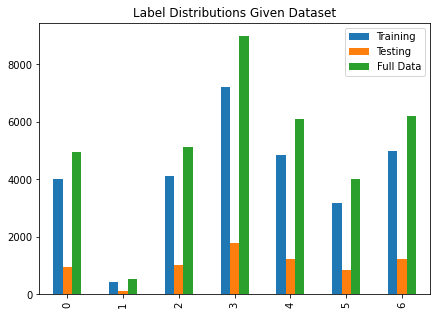

In [85]:
# Plot distributions
counts = {
    'Training': training_counts,
    'Testing': testing_counts,
    'Full Data': full_counts
}

pd.DataFrame(counts).plot(kind='bar', figsize=(7,5))
plt.title('Label Distributions Given Dataset')
plt.show()

It is clear that our data is unbalanced for Classes 1 and 3. Given the time constraint, this could not be addressed other than with data augmentation, so the model will be biased to a degree. However, future improvements and solutions to this problem are discussed in the paper.

## Model Architecture

**(Similar explanation in paper)**

The final model architecture consists of three convolutional blocks, followed by a multilayer perceptron. 

The convolutional blocks are composed of two layers, one convolution and one max pooling. Their purpose is feature extraction. It is common practice that for each convolution layer, the learned filters is multiplied by 2 - this increases the filters as the output spacial volume decreases. Typically, the number of filters is also a power of two. Further, the kernel size was selected as 3x3 for each layer as it is a common choice, and increasing the filter dimensions is only recommended when the input image is greater than 128x128. Because our images are approximately 1/3 of the size, this was unnecessary. In earlier implementations, I experimented with microfilters (1x1), and tried to emulate the microarchitectures of the ResNet/Inception, but it was not possible to explore given the time constraints. It also did not seem to make too large of a difference. For the step size, I left it at the default value 1x1 given that the input images were already small. I left the padding as 'same' so that I could implement Max Pooling layers, although using 'valid' without the Max Pooling layers would give a similar result. Finally, I decided on ReLU activation as trains much faster, has less expensive operations, and is more expressive. ReLU is also the choice for most current deep learning implementations. The following Max Pooling layers use a default of 2x2 pool size, which specifies the dimensions of the pooling window for the resulting feature size. This was the expected choice given the kernel size in the previous convolution layers.

The Flatten layer is simply to prepare the feature maps for input into the Multilayer Perceptron. 

The choice for the Mulitlayer was made through experimentation. I initially tried adding three Dense layers, following the opposite power of two pattern for number of perceptrons as with the filter number in the convolution layers. However, this increase the complexity was too high with little to no performance payoff. Then, I tried a single Dense layer with 32 perceptrons, again not performing well. After testing a single and double layer architecture with 128 and 64 neurons respectively, I decided on 64 due to complexity. The Dropout layer is simply to prevent overfitting. The final Dense layer has seven neurons, each one representing each class. The network outputs seven values, which are normalized and converted from weighted sums into probabilities by the softmax activation function. 

The output for each image is an array of seven values, representing the probability of membership into each respective class. To get a single value, I output the index of the maximum value.


In [12]:
# Define Sequential base
model = Sequential()

# Input layer
model.add(InputLayer(input_shape=(29,48,1)))

# Convolutional block 1
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# Convolutional block 2
model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# Convolutional block 3
model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# Flatten layer
model.add(Flatten())

# Fully-connected network (MLP)
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(7, activation='softmax'))

In [13]:
# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 29, 48, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 24, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 12, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 12, 128)        73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 6, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)             

In [14]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

## Training #1: Original Data

In [9]:
# Fit model to original training data
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
898/898 [==============================] - 92s 102ms/step - loss: 1.7945 - accuracy: 0.2550 - val_loss: 1.7268 - val_accuracy: 0.2921
Epoch 2/20
898/898 [==============================] - 92s 102ms/step - loss: 1.6926 - accuracy: 0.3138 - val_loss: 1.6283 - val_accuracy: 0.3585
Epoch 3/20
898/898 [==============================] - 92s 102ms/step - loss: 1.6041 - accuracy: 0.3693 - val_loss: 1.5584 - val_accuracy: 0.3977
Epoch 4/20
898/898 [==============================] - 91s 102ms/step - loss: 1.5294 - accuracy: 0.4062 - val_loss: 1.4879 - val_accuracy: 0.4221
Epoch 5/20
898/898 [==============================] - 92s 103ms/step - loss: 1.4618 - accuracy: 0.4444 - val_loss: 1.4636 - val_accuracy: 0.4409
Epoch 6/20
898/898 [==============================] - 98s 109ms/step - loss: 1.4065 - accuracy: 0.4640 - val_loss: 1.4473 - val_accuracy: 0.4466
Epoch 7/20
898/898 [==============================] - 92s 102ms/step - loss: 1.3570 - accuracy: 0.4886 - val_loss: 1.4460 - val_ac

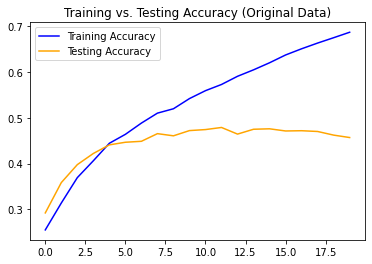

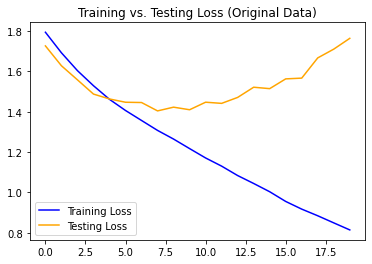

In [10]:
# Plot training and testing trends
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', color='blue',label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', color='orange',label='Testing Accuracy')
plt.title('Training vs. Testing Accuracy (Original Data)')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', color='blue', label='Training Loss')
plt.plot(epochs, val_loss, 'b', color='orange', label='Testing Loss')
plt.title('Training vs. Testing Loss (Original Data)')
plt.legend()

plt.show()

In [11]:
# Get prediction vectors for evaluation
training_results1 = model.predict(X_train)
training_results1 = np.argmax(training_results1, axis=1)

testing_results1 = model.predict(X_test)
testing_results1 = np.argmax(testing_results1, axis=1)

full_results1 = model.predict(data)
full_results1 = np.argmax(full_results1, axis=1)

## Training #2: Augmented Data

In [15]:
# Define Image Data Generator to augment training data
train_gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)

train_generator = train_gen.flow(X_train, y_train, batch_size=64)

In [16]:
# After recompiling Model1 architecture above, fit model to augmented training data
history2 = model.fit(train_generator, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
449/449 [==============================] - 93s 208ms/step - loss: 1.8026 - accuracy: 0.2468 - val_loss: 1.7512 - val_accuracy: 0.2802
Epoch 2/20
449/449 [==============================] - 94s 209ms/step - loss: 1.7424 - accuracy: 0.2827 - val_loss: 1.6926 - val_accuracy: 0.3291
Epoch 3/20
449/449 [==============================] - 94s 209ms/step - loss: 1.6836 - accuracy: 0.3198 - val_loss: 1.6768 - val_accuracy: 0.3300
Epoch 4/20
449/449 [==============================] - 94s 208ms/step - loss: 1.6359 - accuracy: 0.3526 - val_loss: 1.5700 - val_accuracy: 0.3919
Epoch 5/20
449/449 [==============================] - 94s 208ms/step - loss: 1.5890 - accuracy: 0.3794 - val_loss: 1.5164 - val_accuracy: 0.4179
Epoch 6/20
449/449 [==============================] - 93s 207ms/step - loss: 1.5459 - accuracy: 0.4022 - val_loss: 1.5178 - val_accuracy: 0.4178
Epoch 7/20
449/449 [==============================] - 93s 207ms/step - loss: 1.5143 - accuracy: 0.4190 - val_loss: 1.4518 - val_ac

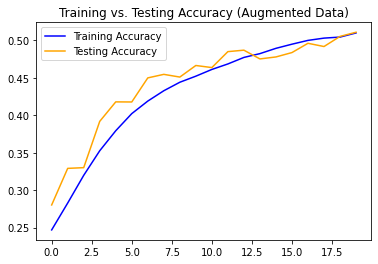

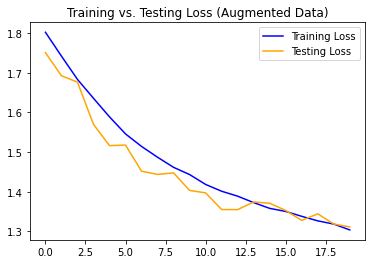

In [17]:
# Plot training and testing trends
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', color='blue',label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', color='orange',label='Testing Accuracy')
plt.title('Training vs. Testing Accuracy (Augmented Data)')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', color='blue', label='Training Loss')
plt.plot(epochs, val_loss, 'b', color='orange', label='Testing Loss')
plt.title('Training vs. Testing Loss (Augmented Data)')
plt.legend()

plt.show()

In [18]:
# Get prediction vectors for evaluation
training_results2 = model.predict(X_train)
training_results2 = np.argmax(training_results2, axis=1)

testing_results2 = model.predict(X_test)
testing_results2 = np.argmax(testing_results2, axis=1)

full_results2 = model.predict(data)
full_results2 = np.argmax(full_results2, axis=1)

## Model Evaluation

In [23]:
# Evaluation function
def evaluate(y_true, y_pred):
  return accuracy_score(y_true, y_pred), precision_score(y_true, y_pred, average='weighted'), \
          recall_score(y_true, y_pred, average='weighted'), \
          f1_score(y_true, y_pred, average='weighted')

#### **Model 1**

In [39]:
# Get metrics
train_acc1, train_pre1, train_re1, train_f11 = evaluate(y_train1D, training_results1)
test_acc1, test_pre1, test_re1, test_f11 = evaluate(y_test1D, testing_results1)
full_acc1, full_pre1, full_re1, full_f11 = evaluate(labels, full_results1)

In [41]:
# Make table
accuracy1 = [train_acc1, test_acc1, full_acc1]
precision1 = [train_pre1, test_pre1, full_pre1]
recall1 = [train_re1, test_re1, full_re1]
f11 = [train_f11, test_f11, full_f11]

model1_metrics = pd.DataFrame(list(zip(accuracy1, precision1, recall1, f11)),
                              columns=['Accuracy', 'Precision (Weighted Average)',
                                       'Recall (Weighted Average)', 
                                       'F1 Score (Weighted Average)'],
                              index=['Training', 'Testing', 'Full'])

print('Model 1 Metrics')
model1_metrics

Model 1 Metrics


,Accuracy,Precision (Weighted Average),Recall (Weighted Average),F1 Score (Weighted Average)
Training,0.773520,0.778645,0.773520,0.773283
Testing,0.456952,0.460889,0.456952,0.455739
Full,0.710201,0.715307,0.710201,0.709862


This model is clearly overfit, despite retraining it for fewer epochs (based on the earlier Accuracy/Loss charts for Model 1). That being said, the accuracy, precision, recall, and F1 scores are all about equivalent, which means that the model is not too biased on first glance. However, considering our unbalanced dataset, and weighted average metrics, our unbalanced dataset could be highly influencing these high numbers.

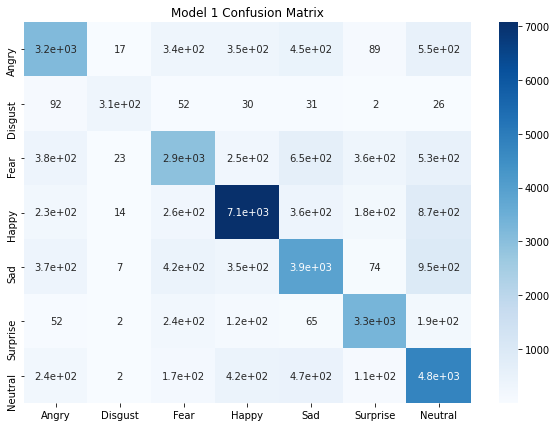

In [51]:
# Full data confusion matrix
cm1 = confusion_matrix(labels, full_results1)

emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

df_cm1 = pd.DataFrame(cm1, index=emotions,
                      columns=emotions)

plt.figure(figsize = (10,7))
plt.title('Model 1 Confusion Matrix')
plt.xlabel=('True')
plt.ylabel=('Predicted')
sn.heatmap(df_cm1, annot=True, cmap='Blues')

As suspected, the model is performing best on Class 3 (Happy) and visually worst on Class 1 (Disgust). This is due to the unbalanced dataset. Model 2 addresses this with data augmentation, whose results are explored next.

#### **Model 2**

In [52]:
# Get metrics
train_acc2, train_pre2, train_re2, train_f12 = evaluate(y_train1D, training_results2)
test_acc2, test_pre2, test_re2, test_f12 = evaluate(y_test1D, testing_results2)
full_acc2, full_pre2, full_re2, full_f12 = evaluate(labels, full_results2)

In [53]:
# Make table
accuracy2 = [train_acc2, test_acc2, full_acc2]
precision2 = [train_pre2, test_pre2, full_pre2]
recall2 = [train_re2, test_re2, full_re2]
f12 = [train_f12, test_f12, full_f12]

model2_metrics = pd.DataFrame(list(zip(accuracy2, precision2, recall2, f12)),
                              columns=['Accuracy', 'Precision (Weighted Average)',
                                       'Recall (Weighted Average)', 
                                       'F1 Score (Weighted Average)'],
                              index=['Training', 'Testing', 'Full'])

print('Model 2 Metrics')
model2_metrics

Model 2 Metrics


,Accuracy,Precision (Weighted Average),Recall (Weighted Average),F1 Score (Weighted Average)
Training,0.568916,0.562238,0.568916,0.558285
Testing,0.511006,0.501283,0.511006,0.498487
Full,0.557333,0.550072,0.557333,0.546349


This model is not overfit, as seen by the previous Accuracy/Loss charts and close metric values. However, as discussed in the Model 1 results, we still to explore the effects of the unbalanced dataset.

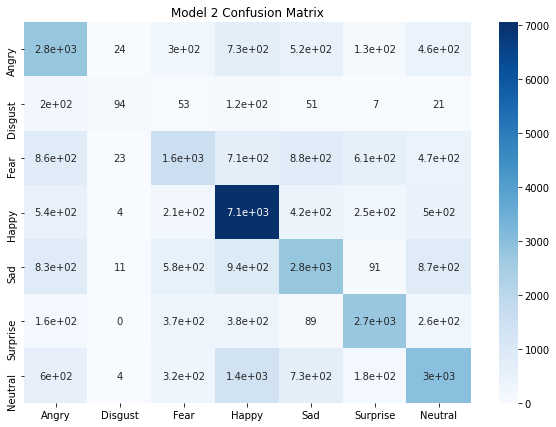

In [55]:
# Full data confusion matrix
cm2 = confusion_matrix(labels, full_results2)

df_cm2 = pd.DataFrame(cm2, index=emotions,
                      columns=emotions)

plt.figure(figsize = (10,7))
plt.title('Model 2 Confusion Matrix')
plt.xlabel=('True')
plt.ylabel=('Predicted')
sn.heatmap(df_cm2, annot=True, cmap='Blues')

This confusion matrix looks similar to that for Model 1, but after looking at the distributions, is better generalized and had higher testing accuracies. That being said, Model 2 will be used in the pipeline.

## Conclusion

Overall, the CNN performed better than expected, given the elimination of the mouth facial feature. However, we suspect that in our pipeline, the tested images sourced independently of the dataset will have unideal results. We expect it to predict 'Happy' majority of the time due to the unbalanced dataset. In the paper, we discuss how we would address this for future improvements.

In [56]:
# Save model and weights
model_json = model.to_json()
with open('/content/drive/My Drive/CPE-695 Final Project/Data/CNN_model_architecture.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('/content/drive/My Drive/CPE-695 Final Project/Data/CNN_model_weights.h5')